1.621332 M parameters
step 0: train loss 4.6220, val loss 4.6232
step 100: train loss 2.5913, val loss 2.5915
step 200: train loss 2.5424, val loss 2.5445
step 300: train loss 2.5081, val loss 2.5070
step 400: train loss 2.4467, val loss 2.4433
step 500: train loss 2.3570, val loss 2.3724
step 600: train loss 2.2875, val loss 2.3020
step 700: train loss 2.2287, val loss 2.2540
step 800: train loss 2.1847, val loss 2.2137
step 900: train loss 2.1413, val loss 2.1784
step 1000: train loss 2.1032, val loss 2.1419
step 1100: train loss 2.0603, val loss 2.1088
step 1200: train loss 2.0331, val loss 2.0821
step 1300: train loss 1.9985, val loss 2.0526
step 1400: train loss 1.9696, val loss 2.0270
step 1500: train loss 1.9389, val loss 1.9990
step 1600: train loss 1.9083, val loss 1.9806
step 1700: train loss 1.8950, val loss 1.9654
step 1800: train loss 1.8660, val loss 1.9471
step 1900: train loss 1.8430, val loss 1.9208
step 2000: train loss 1.8278, val loss 1.9098
step 2100: train loss 1.

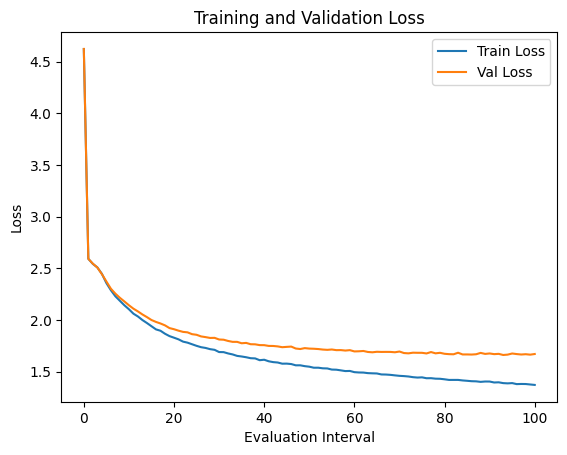

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import os

# hyperparameters
# hyperparameters
batch_size = 64  # how many independent sequences will we process in parallel?
block_size = 128  # maximum context length for predictions
max_iters = 10000
eval_interval = 100
learning_rate = 5e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 192
n_head = 8
n_layer = 12
dropout = 0.25

# dynamic block_size adjustment for GPU memory
#if device == 'cuda':
#device = "cuda"
#gpu_memory = torch.cuda.get_device_properties(0).total_memory
#block_size = min(128, max(16, gpu_memory // (n_embd * 1024)))

print(block_size)
torch.manual_seed(166045)


def custom_loss(logits, targets, expected_syllables=13):
    # Oblicz stratę krzyżową
    ce_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

    # Oblicz liczbę sylab w aktualnym wyniku
    generated_text = decode(targets.tolist())
    syllable_count = count_syllables(generated_text)

    # Penalizuj różnicę od oczekiwanej liczby sylab
    penalty = abs(syllable_count - expected_syllables)
    return ce_loss + 0.1 * penalty  # Waga kary: 0.1





# Load text data
with open('pan-tadeusz.txt', 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split, seq_sampling=False):
    data = train_data if split == 'train' else val_data
    if seq_sampling:
        start_idx = torch.randint(0, len(data) - block_size, (1,)).item()
        x = data[start_idx:start_idx + block_size].unsqueeze(0).repeat(batch_size, 1)
        y = data[start_idx + 1:start_idx + block_size + 1].unsqueeze(0).repeat(batch_size, 1)
    else:
        ix = torch.randint(len(data) - block_size, (batch_size,))
        x = torch.stack([data[i:i + block_size] for i in ix])
        y = torch.stack([data[i + 1:i + block_size + 1] for i in ix])
    return x.to(device), y.to(device)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = x + self.dropout(self.sa(self.ln1(x)))
        x = x + self.dropout(self.ffwd(self.ln2(x)))
        return x

class GPTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens, temperature=1.0):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
    



def calculate_perplexity(logits, targets):
    # Przekształć logits na logarytmy prawdopodobieństw (softmax + log)
    log_probs = F.log_softmax(logits, dim=-1)

    # Spłaszcz targets do wymiaru 1D, aby pasował do logits
    targets = targets.view(-1)

    # Wybierz logarytmy prawdopodobieństw odpowiadające poprawnym tokenom (targets)
    log_probs_target = log_probs[torch.arange(logits.size(0)), targets]

    # Oblicz średni logarytm prawdopodobieństwa na token
    mean_log_prob = log_probs_target.mean()

    # Oblicz perplexity na podstawie wzoru
    perplexity = torch.exp(-mean_log_prob).item()

    return perplexity

def count_syllables(text):
    vowels = "aeiouyąęioó"
    return sum(1 for char in text if char.lower() in vowels)




model = GPTModel().to(device)
print(sum(p.numel() for p in model.parameters()) / 1e6, 'M parameters')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Lists to store metrics
train_losses, val_losses, perplexities_train, perplexities_val = [], [], [], []

# Training loop
for iter in range(max_iters):
    # Collect training metrics for every iteration
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # Save training loss and perplexity for every iteration
    train_losses.append(loss.item())
    perplexities_train.append(calculate_perplexity(logits, yb))

    # Collect validation metrics for every iteration
    X_val, Y_val = get_batch('val')
    logits_val, _ = model(X_val, Y_val)
    val_loss = F.cross_entropy(logits_val.view(-1, logits_val.size(-1)), Y_val.view(-1)).item()
    val_losses.append(val_loss)
    perplexity_val = calculate_perplexity(logits_val, Y_val)
    perplexities_val.append(perplexity_val)

    # Print metrics at eval_interval or the last iteration
    if iter % eval_interval == 0 or iter == max_iters - 1:
        print(f"step {iter}: train loss {train_losses[-1]:.4f}, val loss {val_losses[-1]:.4f}, "
              f"train perplexity {perplexities_train[-1]:.4f}, val perplexity {perplexity_val:.4f}")

import matplotlib.pyplot as plt
import torch

# Create the directory if it doesn't exist
output_dir = "wykresy"
os.makedirs(output_dir, exist_ok=True)

# Plot training and validation perplexity on the same graph
plt.figure()
plt.plot(perplexities_train, label='Nieokreśloność zbiór treningowy', color='blue')
plt.plot(perplexities_val, label='Nieokreśloność zbiór walidacyjny', color='orange')
plt.legend()
plt.xlabel('Epoka')
plt.ylabel('Nieokreśloność')
plt.title('Porównanie: zbiór treningowy vs walidacyjny')
# Save the plot
plt.savefig(os.path.join(output_dir, f'nieokreslonosc_{batch_size}.png'))
plt.close()

# Plot training loss
plt.figure()
plt.plot(train_losses, label='Strata zbiór treningowy', color='blue')
plt.legend()
plt.xlabel('Iteracja')
plt.ylabel('Strata')
plt.title('Strata treningowa w czasie')
# Save the plot
plt.savefig(os.path.join(output_dir, f'strata_treningowa_{batch_size}.png'))
plt.close()

# Plot validation loss
plt.figure()
plt.plot(val_losses, label='Strata zbiór walidacyjny', color='orange')
plt.legend()
plt.xlabel('Iteracja')
plt.ylabel('Strata')
plt.title('Strata walidacyjna w czasie')
# Save the plot
plt.savefig(os.path.join(output_dir, f'strata_walidacyjna_{batch_size}.png'))
plt.close()

# Generate text
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_text = decode(model.generate(context, max_new_tokens=2000)[0].tolist())

# Save generated text to a file
with open(f'wygenerowany_tekst_{batch_size}_{n_embd}_dropout_05.txt', 'w', encoding='utf-8') as f:
    f.write(generated_text)

